# 第七章 &nbsp; &nbsp; 基于RNN生成文本 
在第 5 章和第 6 章中，我们仔细研究了 RNN 和 LSTM 的结构及其实现。现在我们已经在代码层面理解了它们。在本章，RNN 和 LSTM 将大显身手，我们将利用 LSTM 实现几个有趣的应用。

首先，本章将使用语言模型进行文本生成。具体来说，就是使用在语料库上训练好的语言模型生成新的文本。然后，我们将了解如何使用改进过的语言模型生成更加自然的文本。通过这项工作，我们可以（简单地）体验基于 AI 的文本创作。

另外，本章还会介绍一种结构名为 seq2seq 的新神经网络。seq2seq 是 “(from) sequence to sequence”（从时序到时序）的意思，即将一个时序数据转换为另一个时序数据。本章我们将看到，通过组合两个 RNN，可以轻松实现 seq2seq。seq2seq 可以应用于多个应用，比如机器翻译、聊天机器人和邮件自动回复等。通过理解这个简单但聪明强大的 seq2seq，应用深度学习的可能性将进一步扩大。

## 使用语言模型生成文本
我们已经用几章的篇幅讨论了语言模型。如前所述，语言模型可用于各种各样的应用，其中具有代表性的例子有机器翻译、语音识别和文本生成。这里，我们将使用语言模型来生成文本。

## 使用RNN生成文本的步骤
在上一章中，我们使用 LSTM 层实现了语言模型，这个语言模型的网络结构如下图所示。顺便说一下，我们还实现了整体处理（$T$ 个）时序数据的 `Time LSTM` 层和 `Time Affine` 层。

<img src="./fig/language_model_before.png" alt="language_model_before" style="display: block; margin: 0 auto;">

现在我们来说明一下语言模型生成文本的顺序。这里仍以 “you say goodbye and i say hello.” 这一在语料库上学习好的语言模型为例，考虑将单词 `i` 赋给这个语言模型的情况。此时，这个语言模型输出下图中的概率分布。

<img src="./fig/language_model_next_output.png" alt="language_model_next_output" style="display: block; margin: 0 auto;">

语言模型根据已经出现的单词输出下一个出现的单词的概率分布。在上图的例子中，语言模型输出了当给定单词 `i` 时下一个出现的单词的概率分布。那么，它如何生成下一个新单词呢？

一种可能的方法是选择概率最高的单词。在这种情况下，因为选择的是概率最高的单词，所以结果能唯一确定。也就是说，这是一种“确定性的”方法。另一种方法是“概率性地”进行选择。根据概率分布进行选择，这样概率高的单词容易被选到，概率低的单词难以被选到。在这种情况下，被选到的单词（被采样到的单词）每次都不一样。

这里我们想让每次生成的文本有所不同，这样一来，生成的文本富有变化，会更有趣。因此，我们通过后一种方法（概率性地选择的方法）来选择单词。回到我们的例子中，如下图所示，假设（概率性地）选择了单词 `say`。

<img src="./fig/sample_by_possibility.png" alt="sample_by_possibility" style="display: block; margin: 0 auto;">

图中显示了根据概率分布进行采样后结果为 `say` 的例子。在图中的概率分布中，`say` 的概率最高，所以它被采样到的概率也最高。不过请注意，这里选到 `say` 并不是必然的（不是确定性的），而是概率性的。因此，`say` 以外的其他单词根据出现的概率也可能被采样到。

“确定性的”是指（算法的）结果是唯一确定的，是可预测的。在上例中，假设选择概率最高的单词，那么这就是一种确定性的算法。而“概率性的”算法则概率性地确定结果，因此每次实验时选到的单词都会有所变化（或者说，存在变化的可能性）。

接下来，采样第 2 个单词。这只需要重复一下刚才的操作。也就是说，将生成的单词 `say` 输入语言模型，获得单词的概率分布，然后再根据这个概率分布采样下一个出现的单词，如图所示。

<img src="./fig/output_and_sample.png" alt="output_and_sample" style="display: block; margin: 0 auto;">

之后根据需要重复此过程即可（或者直到出现 `<eos>` 这一结尾记号）。这样一来，我们就可以生成新的文本。

这里需要注意的是，像上面这样生成的新文本是训练数据中没有的新生成的文本。因为语言模型并不是背诵了训练数据，而是学习了训练数据中单词的排列模式。如果语言模型通过语料库正确学习了单词的出现模式，我们就可以期待该语言模型生成的文本对人类而言是自然的、有意义的。

## 文本生成的实现
下面我们进行文本生成的实现。这里基于上一章实现的 `Rnnlm` 类，来创建继承自它的 `RnnlmGen` 类，然后向这个类添加生成文本的方法。

类的继承是指继承已有类，创建新的类。在 Python 中，可以通过 <code>class New(Base):</code> 继承 Base 类，创建 New 类。

`RnnlmGen` 类的实现如下所示。

In [1]:
import sys
sys.path.append('..') # 为了导入上层目录的文件而进行的设置
import numpy as np
from common.functions import softmax
from rnnlm import Rnnlm
from better_rnnlm import BetterRnnlm 


class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids=None, sample_size=100): # 生成文本
        """
        start_id: 起始单词的ID
        skip_ids: 采样时跳过的单词ID列表
        sample_size: 采样的单词数
        该函数从start_id开始，逐步采样单词，直到采样到sample_size个单词为止。
        采样时会跳过skip_ids中的单词ID。
        采样的单词ID列表作为函数的返回值。
        """
        word_ids = [start_id] # 生成的单词ID列表

        x = start_id # 当前输入单词ID
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1) # 整理成形状为1 × 1的数组
            score = self.predict(x) # 计算下一个单词的得分
            p = softmax(score.flatten()) # 计算下一个单词的概率分布

            sampled = np.random.choice(len(p), size=1, p=p) # 根据概率分布p采样下一个单词
            if (skip_ids is None) or (sampled not in skip_ids): # 如果采样的单词不在skip_ids中
                x = sampled # 将采样的单词作为下一个输入单词
                word_ids.append(int(x)) # 将采样的单词ID添加到结果列表中

        return word_ids

    def get_state(self):
        return self.lstm_layer.h, self.lstm_layer.c # 返回LSTM的隐藏状态和记忆状态

    def set_state(self, state):
        self.lstm_layer.set_state(*state) # 设置LSTM的隐藏状态和记忆状态

这个类用 `generate(start_id, skip_ids, sample_size)` 生成文本。此处，参数 `start_id` 是第 1 个单词 ID，`sample_size` 表示要采样的单词数量。另外，参数 `skip_ids` 是单词 ID 列表（比如，`[12, 20]`），它指定的单词将不被采样。这个参数用于排除 PTB 数据集中的 `<unk>`、`N` 等被预处理过的单词。

PTB数据集对原始文本进行了预处理，稀有单词被&lt;unk&gt;替换，数字被N替换。另外，我们用&lt;eos&gt;作为文本的分隔符。

`generate()` 方法首先通过 `model.predict(x)` 输出各个单词的得分（得分是正规化之前的值），然后基于 `p = softmax(score)`，使用 Softmax 函数对得分进行正规化，这样就获得了我们想要的概率分布。接下来，使用 `np.random.choice()`，根据这个概率分布 `p` 采样下一个单词。关于 `np.random.choice()`，我们已经在之前的小节说明过了。

model的predict()方法进行的是mini-batch处理，所以输入x必须是二维数组。因此，即使在只输入1个单词ID的情况下，也要将它的批大小视为1，并将其整理成形状为1 × 1的NumPy数组。

现在，使用这个 `RnnlmGen` 类进行文本生成。这里先在完全没有学习的状态（即权重参数是随机初始值的状态）下生成文本，代码如下所示。

In [2]:
import sys
sys.path.append('..') # 为了导入上层目录的文件而进行的设置
from rnnlm_gen import RnnlmGen
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train') # 读取PTB数据集
vocab_size = len(word_to_id) # 词典大小
corpus_size = len(corpus) # 语料库大小

model = RnnlmGen() # 创建RnnlmGen的实例
model.load_params('../ch06Gated RNN/Rnnlm.pkl') # 读取学习好的模型参数

# 设定start单词和skip单词
start_word = 'you' # 起始单词
start_id = word_to_id[start_word] # 起始单词的ID
skip_words = ['N', '<unk>', '$'] # 采样时跳过的单词，如数字、未知单词等
skip_ids = [word_to_id[w] for w in skip_words] # 采样时跳过的单词ID列表

# 文本生成
word_ids = model.generate(start_id, skip_ids) # 生成单词ID列表
txt = ' '.join([id_to_word[i] for i in word_ids]) # 用空格连接所有单词，形成连续的文本字符串
txt = txt.replace(' <eos>', '.\n') # 将<eos>替换为句号和换行符
print(txt)

you can call it it gets and how low and tomorrow say like red is too long a good against take into share groups.
 sun lost to prevent a bit filled falling.
 unilever pfeiffer 's rights of families are slow and replaced agricole doctors co. 's u.s. sales is to have lack of convert additional limit for all.
 recently it may have had shown mergers in the first branch of two pale workers only predict mr. lee is n't able to make any computers in this 30-day lesser effort to present food to the law.
 mr.


这里，第 1 个单词是 you，我们将它的单词 ID 设为 `start_id`，来进行文本生成。另外，指定不参与采样的单词为 `['N', '<unk>', '$']`。生成文本的 `generate()` 方法返回单词 ID 列表，因此需要将单词 ID 列表转化为句子。这可以通过 `txt = ' '.join([id_to_word[i] for i in word_ids])` 这行代码进行。`join()` 方法通过 “‘分隔符’.join(列表)” 这种形式连接单词。下面我们来看一个具体的例子。

```python
>>> ' '.join(['you', 'say', 'goodbye'])
'you say goodbye'
```

运行一下上面的代码，结果如下。

you setback best raised fill steelworkers montgomery kohlberg told beam worthy allied ban swedish aichi mather promptly ramada explicit leslie bets discovery considering campaigns bottom petrie warm large-scale frequent temple grumman bennett ...


如你所见，输出的文本是一堆乱七八糟的单词。不过这可以理解，因为这里的模型权重使用的是随机初始值，所以输出了没有意义的文本。那么，如果换成学习好的语言模型，结果会怎样呢？我们利用上一章学习好的权重来进行文本生成。为此，使用 `model.load_params('../ch06Gated RNN/Rnnlm.pkl')` 读入上一章学习好的权重参数，并生成文本。我们来看一下生成的文本（每次的结果都不一样）。

you 'll include one of them a good problems.  
moreover so if not gene 's corr experience with the heat of bridges a new deficits model is non-violent what it 's a rule must exploit it.  
there 's no tires industry could occur.  
beyond my hours where he is n't going home says and japanese letter.  
knight transplants d.c. turmoil with one-third of voters.  
the justice department is ...

虽然上面的结果中可以看到多处语法错误和意思不通的地方，不过也有几处读起来已经比较像句子了。仔细看的话，这个模型正确生成了主语和动词的组合，比如 “you'll include...” “there's no tires...” “knight transplants...” 等。再者，它在一定程度上理解了形容词和名词的使用方法，比如 “good problems” “japanese letter” 等。另外，开头的 “you'll include one of them a good problems.” 也是一个含义通顺的句子。

如上所述，上面的实验生成的文本在某种程度上可以说是正确的，不过结果中仍有许多不自然的地方，改进空间很大。虽然不存在 “完美的文章”，但是至少我们可以追求更自然的文章。为此，我们应该怎么做呢？当然是使用更好的语言模型！

## 更好的文本生成
如果有更好的语言模型，就可能有更好的文本。在上一章中，我们改进了简单的 RNNLM，实现了 “更好的 RNNLM”，将模型的困惑度从 136 降至 75。现在，我们看一下这个 “更好的 RNNLM” 生成文本的能力。

在上一章中，我们进行了 `BetterRnnlm` 类的学习，并将学习好的权重保存为了文件。这里的实验需要用到这个学习好的权重文件，我们可以从出版社网站的本书主页获取。将这个权重文件放到本书源代码的 `ch06Gated RNN` 目录下，即可运行本实验的代码。

在上一章中，我们将更好的语言模型实现为了 `BetterRnnlm` 类。这里，像刚才一样，继承这个类，并使之有生成文本的能力。`BetterRnnlmGen` 类的实现和刚刚的 `RnnlmGen` 类完全一样，此处省略具体说明。

In [3]:
import sys
sys.path.append('..') # 为了导入上层目录的文件而进行的设置
from common.np import *
from rnnlm_gen import BetterRnnlmGen
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train') # 读取PTB数据集
vocab_size = len(word_to_id) # 词典大小
corpus_size = len(corpus) # 语料库大小


model = BetterRnnlmGen() # 创建BetterRnnlmGen的实例
model.load_params('../ch06Gated RNN/BetterRnnlm.pkl') # 读取学习好的模型参数

# 设定start字符和skip字符
start_word = 'you' # 起始单词
start_id = word_to_id[start_word] # 起始单词的ID
skip_words = ['N', '<unk>', '$'] # 采样时跳过的单词，如数字、未知单词等
skip_ids = [word_to_id[w] for w in skip_words] # 采样时跳过的单词ID列表
# 文本生成
word_ids = model.generate(start_id, skip_ids) # 生成单词ID列表
txt = ' '.join([id_to_word[i] for i in word_ids]) # 用空格连接所有单词，形成连续的文本字符串
txt = txt.replace(' <eos>', '.\n') # 将<eos>替换为句号和换行符

print(txt) 


model.reset_state() # 重置LSTM的隐藏状态和记忆状态

start_words = 'the meaning of life is' # 起始单词序列
start_ids = [word_to_id[w] for w in start_words.split(' ')]  # 起始单词ID列表

for x in start_ids[:-1]: # 除了最后一个单词外，逐个输入起始单词
    x = np.array(x).reshape(1, 1) # 整理成形状为1 × 1的数组
    model.predict(x) # 逐个输入起始单词

word_ids = model.generate(start_ids[-1], skip_ids) # 从最后一个起始单词开始生成单词ID列表
word_ids = start_ids[:-1] + word_ids # 将起始单词ID列表和生成的单词ID列表连接起来
txt = ' '.join([id_to_word[i] for i in word_ids]) # 用空格连接所有单词，形成连续的文本字符串
txt = txt.replace(' <eos>', '.\n') # 将<eos>替换为句号和换行符
print('-' * 50) # 分隔线
print(txt)

you are designed to spread from the industrial area where the initial exhibition was completed but are n't sent to a cure.
 it does n't seem to be determined.
 sheraton a louisville ky. calif. firm said that a series of common losses of the restraints were scheduled to set up with monthly settlements in leipzig indonesia and portugal.
 at mr. johnson 's sr. bears fax an lawsuit on the move is the first to move before saying he says people will be caught in the starting the position if he bought three or two there to be
--------------------------------------------------
the meaning of life is hiring to honor ted flom.
 the best says mrs. paterson says you 're going a big so more shouted in all mr. says referring to the fact that we do n't know how much it will be done.
 jack golden moore.
 columbia s.c.
 you 're shown practices they 're in the country 's door in the third and fourth world.
 dragging a fact that you 'm a novel who was eager to do with him must not make the right to handl

现在，我们让这个更好的语言模型生成文本。和之前一样，第 1 个单词是 `you`。这样一来，下述文本会被生成。

you 've seen two families and the women and two other women of students.  
the principles of investors that prompted a bipartisan rule of which had a withdrawn target of black men or legislators interfere with the number of plants can do to carry it together.  
the appeal was to deny steady increases in the operation of dna and educational damage in the 1950s.  
...

可以看出，这个模型生成了比之前更自然的文本（可能有些主观）。最开始的句子 “you’ve seen two families and the women...” 正确使用了主语、动词和宾语，并且正确学习了 `and` 的使用方法（`two families and the women`）。其他部分读起来总体上也算说得过去。

虽然这里生成的文本仍然存在若干问题（特别是语义方面），但是从某种程度上来说，这个更好的语言模型生成了更加自然的文本。通过进一步改进这个模型，使用更大规模的语料库，应该能创造出更加自然的文本。

最后，我们尝试给这个更好的语言模型输入 “the meaning of life is”，让它生成后续的单词。为了做这个实验，我们按顺序向模型输入 `['the', 'meaning', 'of', 'life']`，进行正向传播。此时不使用任何输出的结果，只是让 LSTM 层记住这些单词的信息。然后，以单词 `is` 作为开始位置，生成 “the meaning of life is” 的后续内容。

每次实验生成的文本都不太一样，这里介绍一个有意思的结果。

``the meaning of life is not a good version of paintings.``

如上所述，语言模型给出的回答是 “人生的意义并不是一种状态良好的绘画”。虽然搞不懂什么才是 “状态良好的绘画”，不过说不定这其中有什么深刻的意义。

## seq2seq模型
这个世界充满了时序数据。文本数据、音频数据和视频数据都是时序数据。另外，还存在许多需要将一种时序数据转换为另一种时序数据的任务，比如机器翻译、语音识别等。其他的还有进行对话的聊天机器人应用、将源代码转为机器语言的编译器等。

像这样，世界上存在许多输入输出均为时序数据的任务。从现在开始，我们会考察将时序数据转换为其他时序数据的模型。作为它的实现方法，我们将介绍使用两个 RNN 的 seq2seq 模型。

## seq2seq的原理
seq2seq 模型也称为 Encoder-Decoder 模型。顾名思义，这个模型有两个模块——Encoder（编码器）和 Decoder（解码器）。编码器对输入数据进行编码，解码器对被编码的数据进行解码。

编码是基于某些既定规则的信息转换过程。以字符码为例，将字符 “A” 转换为 “1000001”（二进制）就是一个编码的例子。而解码则将被编码的信息还原到它的原始形态。仍以字符码为例，这相当于将位模式的 “1000001” 转换为字符 “A”。

现在，我们举一个具体的例子来说明 seq2seq 的机制。这里考虑将日语翻译为英语，比如将 “吾輩は猫である” 翻译为 “I am a cat”。此时，如下图所示，seq2seq 基于编码器和解码器进行时序数据的转换。

<img src="./fig/encoder_decoder_example.png" alt="encoder_decoder_example" style="display: block; margin: 0 auto;">

如图所示，编码器首先对 “吾輩は猫である” 这句话进行编码，然后将编码好的信息传递给解码器，由解码器生成目标文本。此时，编码器编码的信息浓缩了翻译所必需的信息，解码器基于这个浓缩的信息生成目标文本。

以上就是 seq2seq 的全貌图。编码器和解码器协作，将一个时序数据转换为另一个时序数据。另外，在这些编码器和解码器内部可以使用 RNN。下面我们来看一下细节。首先来看编码器，它的层结构如下图所示。

<img src="./fig/encoder.png" alt="encoder" style="display: block; margin: 0 auto;">

由上图可以看出，编码器利用 RNN 将时序数据转换为隐藏状态 $\boldsymbol{h}$。这里的 RNN 使用的是 LSTM，不过也可以使用 “简单 RNN” 或者 GRU 等。另外，这里考虑的是将日语句子分割为单词进行输入的情况。

上图的编码器输出的向量 $\boldsymbol{h}$ 是 LSTM 层的最后一个隐藏状态，其中编码了翻译输入文本所需的信息。这里的重点是，LSTM 的隐藏状态 $\boldsymbol{h}$ 是一个固定长度的向量。说到底，编码就是将任意长度的文本转换为一个固定长度的向量。

<img src="./fig/encoder_example.png" alt="encoder_example" style="display: block; margin: 0 auto;">

如图所示，编码器将文本转换为固定长度的向量。那么，解码器是如何 “处理” 这个编码好的向量，从而生成目标文本的呢？其实，我们已经知道答案了。因为我们只需要直接使用上一节讨论的进行文本生成的模型即可，如下图所示。

<img src="./fig/encoder_layer.png" alt="encoder_layer" style="display: block; margin: 0 auto;">

从图中可以看出，解码器的结构和上一节的神经网络完全相同。不过它和上一节的模型存在一点差异，就是 LSTM 层会接收向量 $\boldsymbol{h}$。在上一节的语言模型中，LSTM 层不接收任何信息（硬要说的话，也可以说 LSTM 的隐藏状态接收 “0 向量”）。这个唯一的、微小的改变使得普通的语言模型进化为可以驾驭翻译的解码器。

图中使用了&lt;eos&gt;这一分隔符（特殊符号）。这个分隔符被用作通知解码器开始生成文本的信号。另外，解码器采样到&lt;eos&gt;出现为止，所以它也是结束信号。也就是说，分隔符&lt;eos&gt;可以用来指示解码器的“开始 / 结束”。在其他文献中，也有使用&lt;go&gt;、&lt;start&gt;或者“_”（下划线）作为分隔符的例子。

现在我们连接编码器和解码器，并给出它的层结构，具体如下图所示。

<img src="./fig/seq2seq_layer.png" alt="seq2seq_layer" style="display: block; margin: 0 auto;">

如图所示，seq2seq 由两个 LSTM 层构成，即编码器的 LSTM 和解码器的 LSTM。此时，LSTM 层的隐藏状态是编码器和解码器的 “桥梁”。在正向传播时，编码器的编码信息通过 LSTM 层的隐藏状态传递给解码器；在反向传播时，解码器的梯度通过这个 “桥梁” 传递给编码器。

---

编码器的核心目标是把任意长度的输入序列，压缩成一个能代表核心语义的“信息包”。而h恰好具备这个属性，c则不适合。
- **h的特性**：编码器LSTM的最后一个h，是经过每一步输入（如日语单词）迭代更新后的“最终状态”。它融合了整个输入序列的**关键语义和时序逻辑**，比如“吾輩は猫である”中“主语是我、宾语是猫、判断句结构”这些核心信息，都被浓缩在h里。可以理解为h是对输入序列的“精炼总结”。
- **c的特性**：编码器的c是“长期记忆仓库”，里面不仅有核心语义，还可能保留了一些**中间冗余信息**（比如输入序列中不重要的助词、语气词痕迹）。这些冗余信息对解码器来说是“噪音”，会干扰生成目标序列的准确性，所以不适合直接传递。

---

## 时序数据转换的简单尝试
下面我们来实现 seq2seq，不过在此之前，首先说明一下我们要处理的问题。这里我们将 “加法” 视为一个时序转换问题。具体来说，如图所示，在 seq2seq 学习后，如果输入字符串 “57 + 5”，seq2seq 要能正确回答 “62”。顺便说一下，这种为了评价机器学习而创建的简单问题，称为 “toy problem”。

<img src="./fig/seq2seq_addition.png" alt="seq2seq_addition" style="display: block; margin: 0 auto;">

在我们看来，这里做的加法运算是非常简单的问题，但是 seq2seq 对加法（更确切地说是加法的逻辑）一无所知。seq2seq 从加法的例子（样本）中学习出现的字符模式，这样真的可以学习到加法运算的规则吗？这正是本次实验的看头。

顺便说一下，在之前的 word2vec 和语言模型中，我们都把文本以单词为单位进行了分割，但并非必须这样做。对于本节的这个问题，我们将不以单词为单位，而是以字符为单位进行分割。在以字符为单位进行分割的情况下，“57 + 5”这样的输入会被处理为 ['5', '7', '+', '5'] 这样的列表。

## 可变长度的时序数据
我们将“加法”视为字符（数字）列表。这里需要注意的是，不同的加法问题（“57 + 5”或者 “628 + 521” 等）及其回答（“62”或者 “1149” 等）的字符数是不同的。比如，“57 + 5”共有 4 个字符，而 “628 + 521” 共有 7 个字符。

如此，在加法问题中，每个样本在时间方向上的大小不同。也就是说，加法问题处理的是可变长度的时序数据。因此，在神经网络的学习中，在进行 mini-batch 处理时，需要想一些应对办法。

在使用批数据进行学习时，会一起处理多个样本。此时，（在我们的实现中）需要保证一个批次内各个样本的数据形状是一致的。

在基于 mini-batch 学习可变长度的时序数据时，最简单的方法是使用填充（padding）。所谓填充，就是用无效（无意义）数据填入原始数据，从而使数据长度对齐。就上面这个加法的例子来说，如图所示，在多余位置插入无效字符（这里是空白字符），从而使所有输入数据的长度对齐。

<img src="./fig/mini_batch_padding.png" alt="mini_batch_padding" style="display: block; margin: 0 auto;">

本次的问题处理的是 0～999 的两个数的加法。因此，包括 “+” 在内，输入的最大字符数是 7。另外，加法的结果最大是 4 个字符（最大为 “999 + 999 = 1998”）。因此，对监督数据也进行类似的填充，从而对齐所有样本数据的长度。另外，在本次的问题中，在输出的开始处加上了分隔符 “_”（下划线），使得输出数据的字符数统一为 5。这个分隔符作为通知解码器开始生成文本的信号使用。

对于解码器的输出，可以在监督标签中插入表示字符输出结束的分隔符（比如 “_62_” 或 “_1149_”）。但是，简单起见，这里我们不使用表示字符输出结束的分隔符。也就是说，在解码器生成字符串时，始终输出固定数量的字符（这里是包括开始处的 “_” 在内的 5 个字符）。

像这样，通过填充对齐数据的大小，可以处理可变长度的时序数据。但是，因为使用了填充，seq2seq 需要处理原本不存在的填充用字符，所以如果追求严谨，使用填充时需要向 seq2seq 添加一些填充专用的处理。比如，在解码器中输入填充时，不应计算其损失（这可以通过向 Softmax with Loss 层添加 mask 功能来解决）。再比如，在编码器中输入填充时，LSTM 层应按原样输出上一时刻的输入。这样一来，LSTM 层就可以像不存在填充一样对输入数据进行编码。

这里的内容有一些复杂，大家即使无法理解也没有关系。为了便于理解，本章我们将填充用字符（空白字符）作为普通数据处理，不进行特别处理。

## 加法数据集
这里介绍的加法的学习数据预先存放在了 `dataset/addition.txt` 中。如图所示，这个文本文件中含有 50 000 个加法样本。这份学习数据的制作参考了 Keras 的 seq2seq 的实现。

<img src="./fig/addition_dataset.png" alt="addition_dataset" style="display: block; margin: 0 auto;">

为了使用 Python 轻松处理 seq2seq 的学习数据（文本文件），本书提供了一个专用模块（`dataset/sequence.py`），这个模块有 `load_data()` 和 `get_vocab()` 两个方法。

`load_data(file_name, seed)` 读入由 `file_name` 指定的文本文件，并将文本转换为字符 ID，返回训练数据和测试数据。该方法内部设有随机数种子 `seed` 以打乱数据，分割训练数据和测试数据。另外，`get_vocab()` 方法返回字符与 ID 的映射字典（实际上返回 `char_to_id` 和 `id_to_char`）。现在我们来看一下实际的使用示例。

In [4]:
import sys
sys.path.append('..') # 为了导入上层目录的文件而进行的设置
from dataset import sequence


(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt', seed=1984) # 读取加法运算数据集
char_to_id, id_to_char = sequence.get_vocab() # 获取字符和ID的对应关系

print(x_train.shape, t_train.shape) 
print(x_test.shape, t_test.shape)
# (45000, 7) (45000, 5)
# (5000, 7) (5000, 5)

print(x_train[0])
print(t_train[0])
# [ 3  0  2  0  0 11  5]
# [ 6  0 11  7  5]

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))
# 71+118
# _189

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 


---

简单来说，字符的ID分配遵循“先到先得”原则，具体逻辑可以拆解为两点：

1. **首次出现即分配ID**
   当`_update_vocab`函数遍历文本时，会检查当前字符是否已存在于`char_to_id`字典中。如果不存在，就立即为其分配一个新ID，ID值等于当前字典的长度（从0开始递增）。
   - 例如，数据集中第一个出现的字符（比如“1”）会被分配ID=0，第二个新字符（比如“+”）分配ID=1，以此类推。

2. **后续出现不重复分配**
   同一字符后续再次出现时（比如在其他问题或答案中），由于已存在于字典中，不会重新分配新ID，直接沿用首次分配的ID。
   - 例如，“1”在第一个问题中被分配ID=0后，后续所有问题或答案中的“1”，都会统一使用ID=0。

这种构建方式的核心是“按首次出现顺序分配唯一ID”，不依赖字符本身的含义（如数字大小、是否为运算符），仅由数据集中的出现顺序决定。

---

像这样，使用 `sequence` 模块，可以轻松地读入 seq2seq 用的数据。这里，`x_train` 和 `t_train` 存放的是字符 ID。另外，字符 ID 和字符之间的映射可以使用 `char_to_id` 和 `id_to_char`。

数据集原本应分成训练用、验证用和测试用3份。用训练数据进行学习，用验证数据进行调参，最后再用测试数据评价模型的能力。而简单起见，这里只分成训练数据和测试数据2份，用它们进行模型的训练和评价。

## seq2seq的实现
seq2seq 是组合了两个 RNN 的神经网络。这里我们首先将这两个 RNN 实现为 `Encoder` 类和 `Decoder` 类，然后将这两个类组合起来，来实现 `seq2seq` 类。我们先从 `Encoder` 类开始介绍。

## Encoder类
如图所示，`Encoder` 类接收字符串，将其转化为向量 $\boldsymbol{h}$。

<img src="./fig/encoder_input_and_output.png" alt="encoder_input_and_output" style="display: block; margin: 0 auto;">

如前所述，我们使用 RNN 实现编码器。这里，使用 LSTM 层实现下图的层结构。

<img src="./fig/encoder_layer_example.png" alt="encoder_layer_example" style="display: block; margin: 0 auto;">

如图所示，`Encoder` 类由 `Embedding` 层和 `LSTM` 层组成。`Embedding` 层将字符（字符 ID）转化为字符向量，然后将字符向量输入 `LSTM` 层。

`LSTM` 层向右（时间方向）输出隐藏状态和记忆单元，向上输出隐藏状态。这里，因为上方不存在层，所以丢弃 `LSTM` 层向上的输出。如图 7-14 所示，在编码器处理完最后一个字符后，输出 `LSTM` 层的隐藏状态 $\boldsymbol{h}$。然后，这个隐藏状态 $\boldsymbol{h}$ 被传递给解码器。

编码器只将LSTM的隐藏状态传递给解码器。尽管也可以把LSTM的记忆单元传递给解码器，但我们通常不太会把LSTM的记忆单元传递给其他层。这是因为，LSTM的记忆单元被设计为只给自身使用。

顺便说一下，我们已经将时间方向上进行整体处理的层实现为了 `Time LSTM` 层和 `Time Embedding` 层。使用这些 `Time` 层，我们的编码器将如图所示。

<img src="./fig/time_encoder.png" alt="time_encoder" style="display: block; margin: 0 auto;">

`Encoder` 类如下所示。这个 `Encoder` 类有初始化 `__init__()`、正向传播 `forward()` 和反向传播 `backward()` 这 3 个方法。首先，我们来看一下初始化方法。

In [5]:
import numpy as np
import sys
sys.path.append('..') # 为了导入上层目录的文件而进行的设置
from common.time_layers import *

class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size # 词典大小、词向量维度、隐藏状态维度
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f') # 词嵌入矩阵
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f') # LSTM的输入权重
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f') # LSTM的隐藏状态权重
        lstm_b = np.zeros(4 * H).astype('f') # LSTM的偏置
        
        self.embed_W = TimeEmbedding(embed_W) # 词嵌入层
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False) # LSTM层

        self.params = self.embed_W.params + self.lstm.params # 所有参数
        self.grads = self.embed_W.grads + self.lstm.grads # 所有梯度
        self.hs = None # LSTM的隐藏状态序列

初始化方法接收 `vocab_size`、`wordvec_size` 和 `hidden_size` 这 3 个参数。`vocab_size` 是词汇量，相当于字符的种类。顺便说一下，这次共有 13 种字符（数字 0~9、“+”、“ ”（空白字符）、“_”）。此外，`wordvec_size` 对应于字符向量的维数，`hidden_size` 对应于 LSTM 层的隐藏状态的维数。

这个初始化方法进行权重参数的初始化和层的生成。最后，将权重参数和梯度分别归纳在成员变量 `params` 和 `grads` 的列表中。因为这次并不保持 `Time LSTM` 层的状态，所以设定 `stateful=False`。

第5章和第6章的语言模型处理的是只有一个长时序数据的问题。那时我们设定Time LSTM层的参数 <code>stateful=True</code>，以在保持隐藏状态的同时，处理长时序数据。而这次是有多个短时序数据的问题。因此，针对每个问题重设LSTM的隐藏状态（为0向量）。

接着来看 `forward()` 方法和 `backward()` 方法。

In [6]:
def forward(self, xs):
    xs = self.embed.forward(xs) # 词嵌入层的前向传播，将单词ID转换为词向量，形状为 (N, T, D)
    hs = self.lstm.forward(xs) # LSTM层的前向传播，形状为 (N, T, H)
    self.hs = hs # 保存LSTM的隐藏状态序列
    return hs[:, -1, :] # 返回最后一个时间步的隐藏状态

def backward(self, dh):
    dhs = np.zeros_like(self.hs) # 初始化隐藏状态序列的梯度，形状与self.hs相同，即 (N, T, H)
    dhs[:, -1, :] = dh # 只在最后一个时间步设置梯度，其他时间步为0
    dout = self.lstm.backward(dhs) # LSTM层的反向传播，得到词嵌入层的梯度，形状为 (N, T, D)
    dout = self.embed.backward(dout) # 词嵌入层的反向传播，得到输入的梯度，形状为 (N, T, D)
    return dout

In [7]:
import sys
sys.path.append('..') # 为了导入上层目录的文件而进行的设置
from common.time_layers import *

class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size # 词典大小、词向量维度、隐藏状态维度
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f') # 词嵌入矩阵
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f') # LSTM的输入权重
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f') # LSTM的隐藏状态权重
        lstm_b = np.zeros(4 * H).astype('f') # LSTM的偏置

        self.embed = TimeEmbedding(embed_W) # 词嵌入层
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False) # LSTM层

        self.params = self.embed.params + self.lstm.params # 所有参数
        self.grads = self.embed.grads + self.lstm.grads # 所有梯度
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs) # 词嵌入层的前向传播，将单词ID转换为词向量，形状为 (N, T, D)
        hs = self.lstm.forward(xs) # LSTM层的前向传播，形状为 (N, T, H)
        self.hs = hs # 保存LSTM的隐藏状态序列
        return hs[:, -1, :]

    def backward(self, dh):
        dhs = np.zeros_like(self.hs) # 初始化隐藏状态序列的梯度，形状与self.hs相同，即 (N, T, H)
        dhs[:, -1, :] = dh  # 只在最后一个时间步设置梯度，其他时间步为0

        dout = self.lstm.backward(dhs) # LSTM层的反向传播，得到词嵌入层的梯度，形状为 (N, T, D)
        dout = self.embed.backward(dout) # 词嵌入层的反向传播，得到输入的梯度，形状为 (N, T, D)
        return dout

编码器的正向传播调用 `Time Embedding` 层和 `Time LSTM` 层的 `forward()` 方法，然后取出 `Time LSTM` 层的最后一个时刻的隐藏状态，将它作为编码器的 `forward()` 方法的输出。

在编码器的反向传播中，LSTM 层的最后一个隐藏状态的梯度是 `dh`，这个 `dh` 是从解码器传来的梯度。在反向传播的实现中，先生成元素为 0 的张量 `dhs`，再将 `dh` 存放到这个 `dhs` 中的对应位置。剩下的就是调用 `Time Embedding` 层和 `Time LSTM` 层的 `backward()` 方法。以上就是 `Encoder` 类的实现。

## Decoder类
下面，我们继续 `Decoder` 类的实现。如下图所示，`Decoder` 类接收 `Encoder` 类输出的 $\boldsymbol{h}$，输出目标字符串。

<img src="./fig/encoder_and_decoder.png" alt="encoder_and_decoder" style="display: block; margin: 0 auto;">

如前所述，解码器可以由 RNN 实现。和编码器一样，这里也使用 LSTM 层，此时解码器的层结构如下图所示。

<img src="./fig/decoder_learning.png" alt="decoder_learning" style="display: block; margin: 0 auto;">

上图显示了解码器在学习时的层结构。这里使用了监督数据 _62 进行学习，此时输入数据是 `['_', '6', '2', ' ']`，对应的输出是 `['6', '2', ' ', ' ']`。

在使用RNN进行文本生成时，学习时和生成时的数据输入方法不同。在学习时，因为已经知道正确解，所以可以整体地输入时序方向上的数据。相对地，在推理时（生成新字符串时），则只能输入第1个通知开始的分隔符（本次为“_”）。然后，基于输出采样1个字符，并将这个采样出来的字符作为下一个输入，如此重复该过程。

顺便说一句，在之前的小节，在进行文本生成时，我们基于 Softmax 函数的概率分布进行了采样，因此生成的文本会随机变动。因为这次的问题是加法，所以我们想消除这种概率性的 “波动”，生成 “确定性的” 答案。为此，这次我们仅选择得分最高的字符。也就是说，是 “确定性” 地选择，而不是 “概率性” 地选择。下图显示了解码器生成字符串的过程。

<img src="./fig/decoder_softmax.png" alt="decoder_softmax" style="display: block; margin: 0 auto;">

如图所示，这里出现了新的 `argmax` 节点，这是获取最大值的索引（本例中是字符 ID）的节点。图中的结构和上一节展示的文本生成时的结构相同。不过这次没有使用 `Softmax` 层，而是从 `Affine` 层输出的得分中选择了最大值的字符 ID。

Softmax层对输入的向量进行正规化。此时，向量元素的值虽然被改变，但是它们的大小关系没有变化。因此，在上图的情况下，可以省略Softmax层。

如上所述，在解码器中，在学习时和在生成时处理 `Softmax` 层的方式是不一样的。因此，`Softmax with Loss` 层交给此后实现的 `Seq2seq` 类处理。如下图所示，`Decoder` 类仅承担 `Time Softmax with Loss` 层之前的部分。

<img src="./fig/decoder.png" alt="decoder" style="display: block; margin: 0 auto;">

由上图可以看出，`Decoder` 类由 `Time Embedding`、`Time LSTM` 和 `Time Affine` 这 3 个层构成。下面，我们来看一下 `Decoder` 层的实现。这里一起给出它的初始化 `__init__()` 方法、正向传播 `forward()` 方法和反向传播 `backward()` 方法。

In [8]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size # 词典大小、词向量维度、隐藏状态维度
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f') # 词嵌入矩阵
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f') # LSTM的输入权重
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f') # LSTM的隐藏状态权重
        lstm_b = np.zeros(4 * H).astype('f') # LSTM的偏置

        affine_W = (rn(H, V) / np.sqrt(H)).astype('f') # 仿射变换的权重
        affine_b = np.zeros(V).astype('f') # 仿射变换的偏置

        self.embed = TimeEmbedding(embed_W) # 词嵌入层
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True) # LSTM层
        self.affine = TimeAffine(affine_W, affine_b) # 仿射变换层

        self.params, self.grads = [], [] # 所有参数和梯度
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h) # 设置LSTM的隐藏状态
        out = self.embed.forward(xs) # 词嵌入层的前向传播，将单词ID转换为词向量，形状为 (N, T, D)
        out = self.lstm.forward(out) # LSTM层的前向传播，形状为 (N, T, H)
        score = self.affine.forward(out) # 仿射变换层的前向传播，形状为 (N, T, V)
        return score
    
    def backwawrd(self, dscore):
        dout = self.affine.backward(dscore) # 仿射变换层的反向传播，得到LSTM层的梯度，形状为 (N, T, H)
        dout = self.lstm.backward(dout) # LSTM层的反向传播，得到词嵌入层的梯度，形状为 (N, T, D)
        dout = self.embed.backward(dout) # 词嵌入层的反向传播，得到输入的梯度，形状为 (N, T, D)
        dh = self.lstm.dh # LSTM的隐藏状态梯度
        return dh

这里仅对反向传播进行一些补充说明。在 `backward()` 的实现中，从上方的 `Softmax with Loss` 层接收梯度 `dscore`，然后按 `Time Affine` 层、`Time LSTM` 层和 `Time Embedding` 层的顺序传播梯度。`Time LSTM` 层将时间方向上的梯度保存在 `Time LSTM` 层的成员变量 `dh` 中，因此取出时间方向上的梯度 `dh`，将其作为 `Decoder` 类的 `backward()` 的输出。

如前所述，`Decoder` 类在学习时和在生成文本时的行为不同。上面的 `forward()` 方法是假定在学习时使用的。我们将 `Decoder` 类生成文本时的方法实现为 `generate()`。

In [9]:
def generate(self, h, start_id, sample_size):
    sampled = [] # 采样的单词ID列表
    sample_id = start_id # 当前采样的单词ID
    self.lstm.set_state(h) # 设置LSTM的隐藏状态

    for _ in range(sample_size):
        x = np.array(sample_id).reshape((1, 1)) # 整理成形状为1 × 1的数组
        out = self.embed.forward(x) # 词嵌入层的前向传播，形状为 (1, 1, D)
        out = self.lstm.forward(out) # LSTM层的前向传播，形状为 (1, 1, H)
        score = self.affine.forward(out) # 仿射变换层的前向传播，形状为 (1, 1, V)

        sample_id = np.argmax(score.flatten()) # 选择概率最高的单词ID
        sampled.append(int(sample_id)) # 将采样的单词ID添加到结果列表中

    return sampled

In [10]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size # 词典大小、词向量维度、隐藏状态维度
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f') # 词嵌入矩阵
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f') # LSTM的输入权重
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f') # LSTM的隐藏状态权重
        lstm_b = np.zeros(4 * H).astype('f') # LSTM的偏置
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f') # 仿射变换的权重
        affine_b = np.zeros(V).astype('f')  # 仿射变换的偏置

        self.embed = TimeEmbedding(embed_W) # 词嵌入层
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True) # LSTM层
        self.affine = TimeAffine(affine_W, affine_b) # 仿射变换层

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h) # 设置LSTM的隐藏状态

        out = self.embed.forward(xs) # 词嵌入层的前向传播，将单词ID转换为词向量，形状为 (N, T, D)
        out = self.lstm.forward(out) # LSTM层的前向传播，形状为 (N, T, H)
        score = self.affine.forward(out) # 仿射变换层的前向传播，形状为 (N, T, V)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore) # 仿射变换层的反向传播，得到LSTM层的梯度，形状为 (N, T, H)
        dout = self.lstm.backward(dout) # LSTM层的反向传播，得到词嵌入层的梯度，形状为 (N, T, D)
        dout = self.embed.backward(dout) # 词嵌入层的反向传播，得到输入的梯度，形状为 (N, T, D)
        dh = self.lstm.dh # LSTM的隐藏状态梯度
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = [] # 采样的单词ID列表
        sample_id = start_id # 当前采样的单词ID
        self.lstm.set_state(h) # 设置LSTM的隐藏状态

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1)) # 整理成形状为1 × 1的数组
            out = self.embed.forward(x) # 词嵌入层的前向传播，形状为 (1, 1, D)
            out = self.lstm.forward(out) # LSTM层的前向传播，形状为 (1, 1, H)
            score = self.affine.forward(out) # 仿射变换层的前向传播，形状为 (1, 1, V)

            sample_id = np.argmax(score.flatten()) # 选择概率最高的单词ID
            sampled.append(int(sample_id)) # 将采样的单词ID添加到结果列表中

        return sampled

这个 `generate()` 方法有 3 个参数，分别是从编码器接收的隐藏状态 `h`、最开始输入的字符 ID `start_id` 和生成的字符数量 `sample_size`。这里重复如下操作：输入一个字符，选择 `Affine` 层输出的得分中最大值的字符 ID。以上就是 `Decoder` 类的实现。

在这次的问题中，需要将编码器的输出h设定给解码器的Time LSTM层。此时，通过设置Time LSTM层为stateful，可以不重设隐藏状态，在保持编码器的h的同时，进行正向传播。

## Seq2seq类
最后来看 `Seq2seq` 类的实现。话虽如此，这里需要做的只是将 `Encoder` 类和 `Decoder` 类连接在一起，然后使用 `Time Softmax with Loss` 层计算损失而已。`Seq2seq` 类的实现如下所示。

In [11]:
import sys
sys.path.append('..') # 为了导入上层目录的文件而进行的设置
from common.time_layers import *
from common.base_model import BaseModel

class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size # 词典大小、词向量维度、隐藏状态维度
        self.encoder = Encoder(V, D, H) # 编码器
        self.decoder = Decoder(V, D, H) # 解码器
        self.softmax = TimeSoftmaxWithLoss() # 时序版Softmax损失层
 
        self.params = self.encoder.params + self.decoder.params # 所有参数
        self.grads = self.encoder.grads + self.decoder.grads # 所有梯度

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:] # 解码器的输入和目标

        h = self.encoder.forward(xs) # 编码器的前向传播，获取隐藏状态
        score = self.decoder.forward(decoder_xs, h) # 解码器的前向传播，计算得分
        loss = self.softmax.forward(score, decoder_ts) # 计算损失
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout) # 反向传播通过Softmax损失层
        dh = self.decoder.backward(dout) # 反向传播通过解码器
        dout = self.encoder.backward(dh) # 反向传播通过编码器
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs) # 编码器的前向传播，获取隐藏状态
        sampled = self.decoder.generate(h, start_id, sample_size) # 解码器生成单词ID列表
        return sampled

`Encoder` 和 `Decoder` 的各类中已经实现了主要的处理，因此这里只是将它们组合起来。以上就是 `Seq2seq` 类的实现。下面我们使用这个 `Seq2seq` 类，来挑战一下加法问题。

## seq2seq的评价
Seq2seq 的学习和基础神经网络的学习具有相同的流程。基础神经网络的学习流程如下：
1. 从训练数据中选择一个 mini-batch
2. 基于 mini-batch 计算梯度
3. 使用梯度更新权重

这里使用之前章节说明过的 `Trainer` 类进行上述操作。另外，seq2seq 针对每个 epoch 求解测试数据（生成字符串），并计算正确率。seq2seq 的学习代码如下所示。

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.56
| epoch 1 |  iter 21 / 351 | time 0[s] | loss 2.53
| epoch 1 |  iter 41 / 351 | time 0[s] | loss 2.17
| epoch 1 |  iter 61 / 351 | time 1[s] | loss 1.96
| epoch 1 |  iter 81 / 351 | time 1[s] | loss 1.92
| epoch 1 |  iter 101 / 351 | time 2[s] | loss 1.87
| epoch 1 |  iter 121 / 351 | time 2[s] | loss 1.85
| epoch 1 |  iter 141 / 351 | time 3[s] | loss 1.83
| epoch 1 |  iter 161 / 351 | time 3[s] | loss 1.79
| epoch 1 |  iter 181 / 351 | time 3[s] | loss 1.77
| epoch 1 |  iter 201 / 351 | time 4[s] | loss 1.77
| epoch 1 |  iter 221 / 351 | time 4[s] | loss 1.76
| epoch 1 |  iter 241 / 351 | time 5[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 5[s] | loss 1.76
| epoch 1 |  iter 281 / 351 | time 6[s] | loss 1.75
| epoch 1 |  iter 301 / 351 | time 6[s] | loss 1.74
| epoch 1 |  iter 321 / 351 | time 6[s] | loss 1.75
| epoch 1 |  iter 341 / 351 | time 7[s] | loss 1.74
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 66

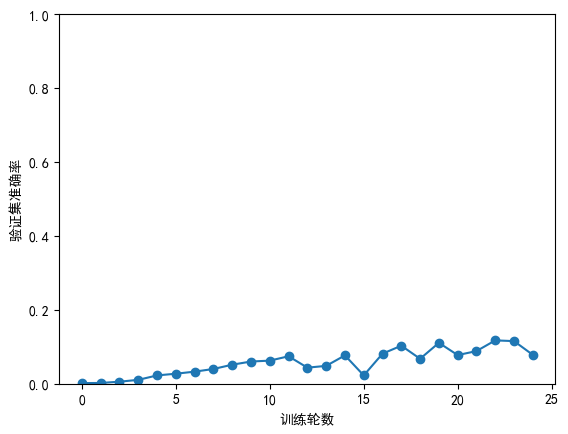

In [12]:
import sys
sys.path.append('..') # 为了导入上层目录的文件而进行的设置
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq
from peeky_seq2seq import PeekySeq2seq
import warnings
warnings.simplefilter('ignore') # 忽略警告信息
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


# 读入数据集
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt') # 读取加法运算数据集
char_to_id, id_to_char = sequence.get_vocab() # 获取字符和ID的对应关系

# 是否反转输入序列（有时反转输入可以提高Seq2Seq模型的性能）
is_reverse = False  # 可以改为True尝试
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1] # 反转输入序列，[:: -1]表示步长为-1，即从后向前取元素
# =========================================================

# 设定超参数
vocab_size = len(char_to_id) # 词典大小
wordvec_size = 16 # 词向量维度
hidden_size = 128 # 隐藏状态维度
batch_size = 128 # 批量大小
max_epoch = 25 # 最大训练轮数
max_grad = 5.0 # 用于梯度裁剪的阈值

# 选择使用基础Seq2Seq还是Peeky Seq2Seq模型 ========================
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# ================================================================
optimizer = Adam() # Adam优化器
trainer = Trainer(model, optimizer) # 训练器

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad) # 训练一个epoch

    correct_num = 0 # 预测正确的样本数
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]] # 取出一个样本，question的形状为(1, 7)，correct的形状为(1, 5)
        verbose = i < 10 # 前10个样本打印详细信息
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse) # 评估样本

    acc = float(correct_num) / len(x_test) # 计算准确率
    acc_list.append(acc) # 记录准确率
    print('验证集准确率 %.3f%%' % (acc * 100)) # 打印验证集准确率

# 绘制图形
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('训练轮数')
plt.ylabel('验证集准确率')
plt.ylim(0, 1.0)
plt.show()

---

Embedding层的维度（即词向量维度）与词典大小之间并没有“必须更小”的严格规则，两者的关系需要结合具体任务和数据特点来分析：

### 1. 通常情况：词向量维度 < 词典大小
在大多数NLP任务中（如文本分类、机器翻译），我们会看到词向量维度（如128、256）远小于词典大小（如几万、几十万）。这是因为：
- **降维作用**：Embedding层的核心功能之一是将高维离散的词ID（维度等于词典大小）映射到低维连续空间，用更紧凑的向量表达语义，减少计算量。
- **泛化能力**：低维向量能更好地学习词与词之间的关联（如“国王-男人+女人≈女王”），而高维向量容易过拟合到具体词语。

比如代码中的加法任务：
- 词典大小（`vocab_size`）很小（可能只有0-9、+、=等十几个字符）
- 词向量维度（16）略大于词典大小，但依然合理（因为任务简单，不需要严格降维）


### 2. 特殊情况：词向量维度 ≥ 词典大小
在以下场景中，词向量维度可以等于或大于词典大小：
- **小词典任务**：当词典规模很小（如代码中的加法问题，只有十几个字符），词向量维度稍大（如16）反而能提升表达能力，且不会增加太多计算成本。
- **需要精细区分的场景**：如果词语之间的差异非常重要（如专业术语库），较大的词向量维度可以保留更多细节。
- **预训练模型**：某些预训练Embedding（如GloVe的大尺寸版本）可能会使用与词典大小接近的维度（如40万词对应300维）。


### 总结
词向量维度与词典大小的关系不是绝对的，核心原则是：
- **小词典任务**：维度可以接近或略大于词典大小（只要不引发过拟合）
- **大词典任务**：维度通常远小于词典大小（兼顾效率和泛化能力）

---

这里显示的代码和基础神经网络的学习用代码是一样的，不过这里采用正确率（正确回答了多少问题）作为评价指标。具体来说，就是针对每个 epoch 对正确回答了测试数据中的多少问题进行统计。

为了测量上述实现的正确率，我们使用 `common/util.py` 中的 `eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse)` 方法。这个方法向模型输入问题，生成字符串，并判断它是否与答案相符。如果模型给出的答案正确，则返回 1；如果错误，则返回 0。

<code>eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse)</code> 方法有6个参数。首先是模型<code>model</code>、问题（字符ID数组）<code>question</code>、正确解（字符ID列表）<code>correct</code>。之后是进行字符ID与字符映射的字典 <code>id_to_char</code>、指定是否显示结果的 <code>verbose</code>、指定是否反转输入语句的 <code>is_reverse</code>。如果设置 <code>verbose = True</code>，则结果会显示在终端上。这次的实验仅显示最初的10份测试数据。另外，关于参数 <code>is_reverse</code>，我们稍后再解释。

运行上述代码后，下图所示的结果会显示在终端（控制台）上。

<img src="./fig/addition_result.png" alt="addition_result" style="display: block; margin: 0 auto;">

如图所示，在终端上，每个 epoch 显示一次结果。每行有 “Q 600 + 257” 这样的问题语句，它的下方是 “T 857” 这样的正确答案。这里，“☒864” 是我们的模型给出的答案。如果我们的模型给出了正确答案，则终端上会显示 “☑864”。

我们再看一下随着学习的进行，上面的结果会发生什么样的变化。下图给出了一个例子。

<img src="./fig/result_change.png" alt="result_change" style="display: block; margin: 0 auto;">

图中展示了随着学习的进行而出现的几个结果。从结果中可知，seq2seq 最开始没能顺利回答问题。但是，随着学习不断进行，它在慢慢靠近正确答案，然后变得可以正确回答一些问题。下面，我们来绘制一下每个 epoch 的正确率，结果如下图所示。

<img src="./fig/correct.png" alt="correct" style="display: block; margin: 0 auto;">

由图可知，随着学习的积累，正确率稳步提高。本次的实验只进行了 25 次，最后的正确率约为 10%。从图中的变化趋势可知，如果继续学习，正确率应该还会进一步上升。不过，为了能更好地学习相同的问题（加法问题），这里我们暂停本次学习，对 seq2seq 进行一些改进。

## seq2seq的改进
本节我们对上一节的 seq2seq 进行改进，以改进学习的进展。为了达成该目标，可以使用一些比较有前景的技术。本节我们展示其中的两个方案，并基于实验确认它们的效果。

## 反转输入数据（Reverse）
第一个改进方案是非常简单的技巧。如下图所示，反转输入数据的顺序。

<img src="./fig/Reverse.png" alt="Reverse" style="display: block; margin: 0 auto;">

这个反转输入数据的技巧是文献中提出来的。据研究，在许多情况下，使用这个技巧后，学习进展得更快，最终的精度也有提高。现在我们来做一下实验。

为了反转输入数据，对于上一节的学习用代码，在读入数据集之后，我们追加下面的代码。

```python
# 读入数据集
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')

...

x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

...
```

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.56
| epoch 1 |  iter 21 / 351 | time 0[s] | loss 2.52
| epoch 1 |  iter 41 / 351 | time 1[s] | loss 2.17
| epoch 1 |  iter 61 / 351 | time 1[s] | loss 1.96
| epoch 1 |  iter 81 / 351 | time 2[s] | loss 1.91
| epoch 1 |  iter 101 / 351 | time 2[s] | loss 1.87
| epoch 1 |  iter 121 / 351 | time 3[s] | loss 1.86
| epoch 1 |  iter 141 / 351 | time 3[s] | loss 1.84
| epoch 1 |  iter 161 / 351 | time 4[s] | loss 1.80
| epoch 1 |  iter 181 / 351 | time 4[s] | loss 1.78
| epoch 1 |  iter 201 / 351 | time 5[s] | loss 1.77
| epoch 1 |  iter 221 / 351 | time 6[s] | loss 1.77
| epoch 1 |  iter 241 / 351 | time 6[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 7[s] | loss 1.75
| epoch 1 |  iter 281 / 351 | time 7[s] | loss 1.74
| epoch 1 |  iter 301 / 351 | time 8[s] | loss 1.74
| epoch 1 |  iter 321 / 351 | time 8[s] | loss 1.74
| epoch 1 |  iter 341 / 351 | time 9[s] | loss 1.73
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 66

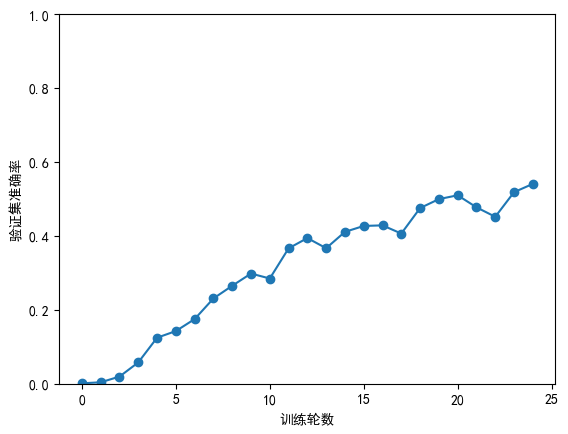

In [13]:
import sys
sys.path.append('..') # 为了导入上层目录的文件而进行的设置
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq
from peeky_seq2seq import PeekySeq2seq
import warnings
warnings.simplefilter('ignore') # 忽略警告信息
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 读入数据集
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt') # 读取加法运算数据集
char_to_id, id_to_char = sequence.get_vocab() # 获取字符和ID的对应关系

# 是否反转输入序列（有时反转输入可以提高Seq2Seq模型的性能）
is_reverse = True  # 可以改为True尝试
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1] # 反转输入序列，[:: -1]表示步长为-1，即从后向前取元素
# =========================================================

# 设定超参数
vocab_size = len(char_to_id) # 词典大小
wordvec_size = 16 # 词向量维度
hidden_size = 128 # 隐藏状态维度
batch_size = 128 # 批量大小
max_epoch = 25 # 最大训练轮数
max_grad = 5.0 # 用于梯度裁剪的阈值

# 选择使用基础Seq2Seq还是Peeky Seq2Seq模型 ========================
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# ================================================================
optimizer = Adam() # Adam优化器
trainer = Trainer(model, optimizer) # 训练器

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad) # 训练一个epoch

    correct_num = 0 # 预测正确的样本数
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]] # 取出一个样本，question的形状为(1, 7)，correct的形状为(1, 5)
        verbose = i < 10 # 前10个样本打印详细信息
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse) # 评估样本

    acc = float(correct_num) / len(x_test) # 计算准确率
    acc_list.append(acc) # 记录准确率
    print('验证集准确率 %.3f%%' % (acc * 100)) # 打印验证集准确率

# 绘制图形
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('训练轮数')
plt.ylabel('验证集准确率')
plt.ylim(0, 1.0)
plt.show()

如上所示，可以使用 `x_train[:, ::-1]` 反转数组的排列。那么，通过反转输入数据，正确率可以上升多少呢？结果如图所示。

<img src="./fig/Reverse_result.png" alt="Reverse_result" style="display: block; margin: 0 auto;">

从图中可知，仅仅通过反转输入数据，学习的进展就得到了改善！在 25 个 epoch 时，正确率为 50% 左右。再次重复一遍，这里和上一次（图中的 baseline）的差异只是将数据反转了一下。仅仅这样，就产生了这么大的差异，真是令人吃惊。当然，虽然反转数据的效果因任务而异，但是通常都会有好的结果。

为什么反转数据后，学习进展变快，精度提高了呢？虽然理论上不是很清楚，但是直观上可以认为，反转数据后梯度的传播可以更平滑。比如，考虑将 “吾輩 は 猫 で ある”翻译成 “I am a cat” 这一问题，单词 “吾輩” 和单词 “I” 之间有转换关系。此时，从 “吾輩” 到 “I” 的路程必须经过 “は”“猫”“で”“ある” 这 4 个单词的 LSTM 层。因此，在反向传播时，梯度从 “I” 抵达 “吾輩”，也要受到这个距离的影响。

那么，如果反转输入语句，也就是变为 “ある で 猫 は 吾輩”，结果会怎样呢？此时，“吾輩” 和 “I” 彼此相邻，梯度可以直接传递。如此，因为通过反转，输入语句的开始部分和对应的转换后的单词之间的距离变近（这样的情况变多），所以梯度的传播变得更容易，学习效率也更高。不过，在反转输入数据后，单词之间的 “平均” 距离并不会发生改变。

## 偷窥（Peeky）
接下来是 seq2seq 的第二个改进。在进入正题之前，我们再看一下编码器的作用。如前所述，编码器将输入语句转换为固定长度的向量 $\boldsymbol{h}$，这个 $\boldsymbol{h}$ 集中了解码器所需的全部信息。也就是说，它是解码器唯一的信息源。但是，如图所示，当前的 seq2seq 只有最开始时刻的 LSTM 层利用了 $\boldsymbol{h}$。我们能更加充分地利用这个 $\boldsymbol{h}$ 吗？

<img src="./fig/LSTM_h.png" alt="LSTM_h" style="display: block; margin: 0 auto;">

为了达成该目标，seq2seq 的第二个改进方案就应运而生了。具体来说，就是将这个集中了重要信息的编码器的输出 $\boldsymbol{h}$ 分配给解码器的其他层。我们的解码器可以考虑图中的网络结构。

<img src="./fig/decoder_change.png" alt="decoder_change" style="display: block; margin: 0 auto;">

如图所示，将编码器的输出 $\boldsymbol{h}$ 分配给所有时刻的 `Affine` 层和 `LSTM` 层。比较可知，之前 `LSTM` 层专用的重要信息 $\boldsymbol{h}$ 现在在多个层（在这个例子中有 8 个层）中共享了。重要的信息不是一个人专有，而是多人共享，这样我们或许可以做出更加正确的判断。

这里的改进是将编码好的信息分配给解码器的其他层，这可以解释为其他层也能“偷窥”到编码信息。因为“偷窥”的英语是 <code>peek</code>，所以将这个改进了的解码器称为 <code>Peeky Decoder</code>。同理，将使用了 <code>Peeky Decoder</code> 的 seq2seq 称为 <code>Peeky seq2seq</code>。

在上图中，有两个向量同时被输入到了 `LSTM` 层和 `Affine` 层，这实际上表示两个向量的拼接（`concatenate`）。因此，在刚才的图中，如果使用 `concat` 节点拼接两个向量，则正确的计算图可以绘制成下图。

<img src="./fig/concat.png" alt="concat" style="display: block; margin: 0 auto;">

下面给出 `PeekyDecoder` 类的实现。这里仅显示初始化 `__init__()` 方法和正向传播 `forward()` 方法。因为没有特别难的地方，所以这里省略了反向传播 `backward()` 方法和文本生成 `generate()` 方法。

In [14]:
import sys
sys.path.append('..') # 为了导入上层目录的文件而进行的设置
from common.time_layers import *
from seq2seq import Seq2seq, Encoder


class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size # 词典大小、词向量维度、隐藏状态维度
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f') # 词嵌入矩阵
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f') # LSTM的输入权重
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f') # LSTM的隐藏状态权重
        lstm_b = np.zeros(4 * H).astype('f') # LSTM的偏置
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f') # 仿射变换的权重
        affine_b = np.zeros(V).astype('f') # 仿射变换的偏置

        self.embed = TimeEmbedding(embed_W) # 词嵌入层
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True) # LSTM层
        self.affine = TimeAffine(affine_W, affine_b) # 仿射变换层

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape # xs的形状为 (N, T)
        N, H = h.shape # h的形状为 (N, H)

        self.lstm.set_state(h) # 设置LSTM的隐藏状态

        out = self.embed.forward(xs) # 词嵌入层的前向传播，将单词ID转换为词向量，形状为 (N, T, D)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H) # h在时间轴上重复，形状为 (N, T, H)
        out = np.concatenate((hs, out), axis=2) # 将hs和out在特征维度上连接，形状为 (N, T, H + D)

        out = self.lstm.forward(out) # LSTM层的前向传播，形状为 (N, T, H)
        out = np.concatenate((hs, out), axis=2) # 将hs和out在特征维度上连接，形状为 (N, T, H + H)

        score = self.affine.forward(out) # 仿射变换层的前向传播，形状为 (N, T, V)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache # 从缓存中获取隐藏状态的维度

        dout = self.affine.backward(dscore) # 仿射变换层的反向传播，得到LSTM层的梯度，形状为 (N, T, H + H)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H] # 分离出LSTM的输出梯度和h的梯度
        dout = self.lstm.backward(dout) # LSTM层的反向传播，得到词嵌入层的梯度，形状为 (N, T, D + H)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H] # 分离出词嵌入层的梯度和h的梯度
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1 # 将两个h的梯度相加
        dh = self.lstm.dh + np.sum(dhs, axis=1) # 计算最终的h的梯度
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = [] # 采样的单词ID列表
        char_id = start_id # 当前采样的单词ID
        self.lstm.set_state(h) # 设置LSTM的隐藏状态

        H = h.shape[1] # 隐藏状态的维度
        peeky_h = h.reshape(1, 1, H) # 形状为 (1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1)) # 整理成形状为1 × 1的数组
            out = self.embed.forward(x) # 词嵌入层的前向传播，形状为 (1, 1, D)

            out = np.concatenate((peeky_h, out), axis=2) # 将peeky_h和out在特征维度上连接，形状为 (1, 1, H + D)
            out = self.lstm.forward(out) # LSTM层的前向传播，形状为 (1, 1, H)
            out = np.concatenate((peeky_h, out), axis=2) # 将peeky_h和out在特征维度上连接，形状为 (1, 1, H + H)
            score = self.affine.forward(out) # 仿射变换层的前向传播，形状为 (1, 1, V)

            char_id = np.argmax(score.flatten()) # 选择概率最高的单词ID
            sampled.append(char_id) # 将采样的单词ID添加到结果列表中

        return sampled

`PeekyDecoder` 的初始化和上一节的 `Decoder` 基本上是一样的，不同之处仅在于 `LSTM` 层权重和 `Affine` 层权重的形状。因为这次的实现要接收编码器编码好的向量，所以权重参数的形状相应地变大了。

接着是 `forward()` 的实现。这里首先使用 `np.repeat()` 根据时序大小复制相应份数的 `h`，并将其设置为 `hs`。然后，将 `hs` 和 `Embedding` 层的输出用 `np.concatenate()` 拼接，并输入 `LSTM` 层。同样地，`Affine` 层的输入也是 `hs` 和 `LSTM` 层的输出的拼接。

编码器和上一节没有变化，因此直接使用上一节的编码器。

最后，我们来实现 `PeekySeq2seq`，不过这和上一节的 `Seq2seq` 类基本相同，唯一的区别是 `Decoder` 层。上一节的 `Seq2seq` 类使用了 `Decoder` 类，与此相对，这里使用 `PeekyDecoder`，剩余的逻辑完全一样。因此，`PeekySeq2seq` 类的实现只需要继承上一章的 `Seq2seq` 类，并修改一下初始化部分。

In [15]:
from seq2seq import Seq2seq, Encoder

class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

至此，准备工作就完成了。现在我们使用这个 `PeekySeq2seq` 类，再次挑战加法问题。学习用代码仍使用上一节的代码，只需要将 `Seq2seq` 类换成 `PeekySeq2seq` 类。

```python
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
```

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.57
| epoch 1 |  iter 21 / 351 | time 0[s] | loss 2.48
| epoch 1 |  iter 41 / 351 | time 1[s] | loss 2.20
| epoch 1 |  iter 61 / 351 | time 1[s] | loss 1.99
| epoch 1 |  iter 81 / 351 | time 2[s] | loss 1.89
| epoch 1 |  iter 101 / 351 | time 3[s] | loss 1.82
| epoch 1 |  iter 121 / 351 | time 3[s] | loss 1.82
| epoch 1 |  iter 141 / 351 | time 4[s] | loss 1.80
| epoch 1 |  iter 161 / 351 | time 4[s] | loss 1.79
| epoch 1 |  iter 181 / 351 | time 5[s] | loss 1.78
| epoch 1 |  iter 201 / 351 | time 6[s] | loss 1.77
| epoch 1 |  iter 221 / 351 | time 6[s] | loss 1.76
| epoch 1 |  iter 241 / 351 | time 7[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 7[s] | loss 1.75
| epoch 1 |  iter 281 / 351 | time 8[s] | loss 1.74
| epoch 1 |  iter 301 / 351 | time 9[s] | loss 1.74
| epoch 1 |  iter 321 / 351 | time 9[s] | loss 1.73
| epoch 1 |  iter 341 / 351 | time 10[s] | loss 1.73
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1013
---
Q 582+84 
T 6

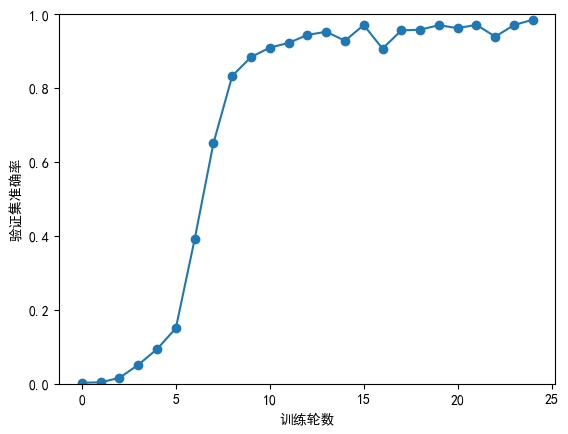

In [16]:
import sys
sys.path.append('..') # 为了导入上层目录的文件而进行的设置
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq
from peeky_seq2seq import PeekySeq2seq
import warnings
warnings.simplefilter('ignore') # 忽略警告信息
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 读入数据集
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt') # 读取加法运算数据集
char_to_id, id_to_char = sequence.get_vocab() # 获取字符和ID的对应关系

# 是否反转输入序列（有时反转输入可以提高Seq2Seq模型的性能）
is_reverse = True  # 可以改为True尝试
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1] # 反转输入序列，[:: -1]表示步长为-1，即从后向前取元素
# =========================================================

# 设定超参数
vocab_size = len(char_to_id) # 词典大小
wordvec_size = 16 # 词向量维度
hidden_size = 128 # 隐藏状态维度
batch_size = 128 # 批量大小
max_epoch = 25 # 最大训练轮数
max_grad = 5.0 # 用于梯度裁剪的阈值

# 选择使用基础Seq2Seq还是Peeky Seq2Seq模型 ========================
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
# ================================================================
optimizer = Adam() # Adam优化器
trainer = Trainer(model, optimizer) # 训练器

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1, batch_size=batch_size, max_grad=max_grad) # 训练一个epoch

    correct_num = 0 # 预测正确的样本数
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]] # 取出一个样本，question的形状为(1, 7)，correct的形状为(1, 5)
        verbose = i < 10 # 前10个样本打印详细信息
        correct_num += eval_seq2seq(model, question, correct, id_to_char, verbose, is_reverse) # 评估样本

    acc = float(correct_num) / len(x_test) # 计算准确率
    acc_list.append(acc) # 记录准确率
    print('验证集准确率 %.3f%%' % (acc * 100)) # 打印验证集准确率

# 绘制图形
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('训练轮数')
plt.ylabel('验证集准确率')
plt.ylim(0, 1.0)
plt.show()

这里，我们在第一个改进（反转输入）的基础上进行实验，结果如图所示。

<img src="./fig/reverse_peeky.png" alt="reverse_peeky" style="display: block; margin: 0 auto;">

如图所示，加上了 Peeky 的 seq2seq 的结果大幅变好。刚过 10 个 epoch 时，正确率已经超过 90%，最终的正确率接近 100%。

从上述实验结果可知，Reverse 和 Peeky 都有很好的效果。借助反转输入语句的 Reverse 和共享编码器信息的 Peeky，我们获得了令人满意的结果！

这样我们就结束了对 seq2seq 的改进，不过故事仍在继续。实际上，本节的改进只能说是 “小改进”，下一章我们将对 seq2seq 进行 “大改进”。届时将使用名为 Attention 的技术，它能使 seq2seq 发生巨大变化。

这里的实验有几个需要注意的地方。因为使用 Peeky 后，网络的权重参数会额外地增加，计算量也会增加，所以这里的实验结果必须考虑到相应地增加的 “负担”。另外，seq2seq 的精度会随着超参数的调整而大幅变化。虽然这里的结果是可靠的，但是在实际问题中，它的效果可能不稳定。

## seq2seq的应用
seq2seq 将某个时序数据转换为另一个时序数据，这个转换时序数据的框架可以应用在各种各样的任务中，比如以下几个例子。
- 机器翻译：将 “一种语言的文本” 转换为 “另一种语言的文本”
- 自动摘要：将 “一个长文本” 转换为 “短摘要”
- 问答系统：将 “问题” 转换为 “答案”
- 邮件自动回复：将 “接收到的邮件文本” 转换为 “回复文本”

像这样，seq2seq 可以用于处理成对的时序数据的问题。除了自然语言之外，也可以用于语音、视频等数据。有些乍一看不属于 seq2seq 的问题，通过对输入输出数据进行预处理，也可以应用 seq2seq。本节将介绍几个使用 seq2seq 的应用。如果读者能由此感受到 seq2seq 的潜力和乐趣，那就再好不过了。

##1 聊天机器人
聊天机器人是人和计算机使用文本进行对话的程序，现在已经被用于 Facebook、Twitter 等各种各样的服务中。

毫无疑问，聊天机器人可以使用 seq2seq。因为对话是由 “对方的发言” 和 “本方的发言” 构成的，可以理解为是将 “对方的发言” 转换为 “本方的发言” 的问题。也就是说，如果有对话文本数据，seq2seq 就可以学习它。

另外，聊天机器人也可以用在实用场景中。文献进行了将基于 seq2seq 的聊天机器人应用于 IT 帮助台的实验，并展示了它成功解决有关 VPN 接入问题的例子。这里，我们将其中的一部分对话翻译成中文。

<img src="./fig/seq2seq_chat.png" alt="seq2seq_chat" style="display: block; margin: 0 auto;">

从图中可知，机器（聊天机器人）很好地解决了问题，遇到 VPN 接入问题的人被引导到了能解决该问题的 URL。当然，它只能解决与 IT 帮助台相关的问题，无法泛化。但是，基于对话获取答案或者线索，这一点非常实用，应用范围很广。实际上，这样的服务（简易版）已经可以在若干网站上看到。

## 算法学习
本章进行的 seq2seq 实验是加法这样的简单问题，但理论上它也能处理更加高级的问题，比如下图所示的 Python 代码。

<img src="./fig/python_example.png" alt="python_example" style="display: block; margin: 0 auto;">

源代码也是用字符编写的时序数据。我们可以将跨行的代码处理为一条语句（将换行视为换行符）。因此，可以直接将源代码输入 seq2seq，让 seq2seq 对源代码与目标答案一起进行学习。

上述包含 for 语句和 if 语句的问题不太容易解决。不过，即便是这样的问题，也可以在 seq2seq 框架内处理。通过改造 seq2seq 的结构，可以期待这样的问题能够被解决。

下一章将介绍 RNN 的扩展——NTM（Neural Turing Machine，神经图灵机）模型。届时计算机（图灵机）将学习内存的读写顺序，重现算法。

## 自动图像描述
到目前为止，我们只看了处理文本的 seq2seq 的应用示例，除了文本之外，seq2seq 还可以处理图像、语音等类型的数据。本节我们来看一下将图像转换为文本的自动图像描述（image captioning）。

自动图像描述将 “图像” 转换为 “文本”。如图所示，这也可以在 seq2seq 的框架下解决。

<img src="./fig/auto_image.png" alt="auto_image" style="display: block; margin: 0 auto;">

上图是我们熟悉的网络结构。实际上，它和之前的网络的唯一区别在于，编码器从 LSTM 换成了 CNN（Convolutional Neural Network，卷积神经网络），而解码器仍使用与之前相同的网络。仅通过这点改变（用 CNN 替代 LSTM），seq2seq 就可以处理图像了。

这里补充说明一下图中的 CNN。此处，CNN 对图像进行编码，这时 CNN 的最终输出是特征图。因为特征图是三维（高、宽、通道）的，所以需要想一些办法让解码器的 LSTM 可以处理它。于是，我们将 CNN 的特征图扁平化到一维，并基于全连接的 Affine 层进行转换。之后，再将转换后的数据传递给解码器，就可以像之前一样生成文本了。

图中的CNN使用VGG、ResNet等成熟网络，并使用在别的图像数据集（ImageNet等）上学习好的权重，这样可以获得好的编码，从而生成好的文本。

现在我们看几个基于 seq2seq 的自动图像描述的例子。下图显示的是由基于 TensorFlow 的 im2txt生成的例子。此处使用的网络基于上图，并在其上进行了若干改进。

<img src="./fig/auto_image_example.png" alt="auto_image_example" style="display: block; margin: 0 auto;">

由图可知，这里得到了很不错的结果。之所以能够达到这样的效果，是因为存在大量的图像和说明文字等训练数据（比如，ImageNet 等大规模的图像数据）。再加上可以高效学习这些训练数据的 seq2seq 的应用，最终得到了上图所示的出色结果。

## 小结
- 基于 RNN 的语言模型可以生成新的文本
- 在进行文本生成时，重复“输入一个单词（字符），基于模型的输出（概率分布）进行采样”这一过程
- 通过组合两个 RNN，可以将一个时序数据转换为另一个时序数据（seq2seq）
- 在 seq2seq 中，编码器对输入语句进行编码，解码器接收并解码这个编码信息，获得目标输出语句
- 反转输入语句（Reverse）和将编码信息分配给解码器的多个层（Peeky）可以有效提高 seq2seq 的精度
- seq2seq 可以用在机器翻译、聊天机器人和自动图像描述等各种各样的应用中